In [2]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import * 

%load_ext autoreload
%autoreload 2

niks_domain = '[XNGDRYS]IK[SDLT]'
ycf_domain = 'Y.C...F'

In [3]:
def get_genome_id_numbers(genome_ids):
    return np.array([re.search(r'(\d{2,})', genome_id).group(1) for genome_id in genome_ids])

In [4]:
gtdb_metadata_df = pd.read_csv('../data/ar53_metadata_r226.tsv', sep='\t')
gtdb_metadata_df.accession = [genome_id.replace('RS_','').replace('GB_', '') for genome_id in gtdb_metadata_df.accession]
gtdb_metadata_df['genus'] = gtdb_metadata_df.gtdb_taxonomy.apply(get_genus)
gtdb_metadata_df['order'] = gtdb_metadata_df.gtdb_taxonomy.apply(get_order)
gtdb_metadata_df = gtdb_metadata_df[gtdb_metadata_df.checkm_completeness > 80].copy()
gtdb_metadata_df = gtdb_metadata_df.set_index('accession')

gtdb_genome_ids = gtdb_metadata_df.gtdb_genome_representative.unique()
gtdb_genome_ids = [genome_id.replace('RS_','').replace('GB_', '') for genome_id in gtdb_genome_ids]

print('Num. GTDB representatives with CheckM completeness > 80%::', len(gtdb_genome_ids))

table_2_metadata_df = load_kivenson_table_2_metadata() # This table only provides the genus. 
table_5_metadata_df = load_kivenson_table_5_metadata() # This table includes full GTDB taxonomy. 

kivenson_genome_ids = np.unique(table_2_metadata_df.index.tolist() + table_5_metadata_df.index.tolist()).tolist()
print('Num. genomes from Kivenson et. al. 2023:', len(kivenson_genome_ids))

genome_ids = list(set(kivenson_genome_ids + gtdb_genome_ids))

# downloader = NCBI()
# downloader.get_genomes(genome_ids)
# extract()


Num. GTDB representatives with CheckM completeness > 80%:: 4907
Num. genomes from Kivenson et. al. 2023: 437


In [5]:
genome_metadata_df = pd.concat([gtdb_metadata_df, table_2_metadata_df, table_5_metadata_df])
genome_metadata_df = genome_metadata_df[~genome_metadata_df.index.duplicated(keep='first')].copy()

# Get the names of the genome IDs which were successfully downloaded.
genome_ids = [file_name.replace('.fn', '') for file_name in os.listdir('../data/ncbi/genomes/')]
genome_ids = np.intersect1d(genome_ids, genome_metadata_df.index)
genome_metadata_df = genome_metadata_df.loc[genome_ids].copy()

print('Num. total genomes:', len(genome_ids))

# Only 6 genomes are missing an order assignment. (genome_metadata_df['order'] == 'none').sum()

Num. total genomes: 4978


In [6]:
# for path in tqdm(glob.glob('../data/ncbi/genomes/*'), 'Running Prodigal with default code on Archaeal genomes.'):
#     output_path = os.path.basename(path).replace('.fn', '.fa')
#     output_path = os.path.join('../data/prodigal', output_path)
#     if not os.path.exists(output_path):
#         subprocess.run(f'prodigal -i {path} -a {output_path}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# for path in tqdm(glob.glob('../data/prodigal/*'), 'Running HMM search on Prodigal outputs.'):
#     output_path = os.path.basename(path).replace('.fa', '.tab')
#     output_path = os.path.join('../data/hmmer', output_path)
#     if not os.path.exists(output_path):
#         try:
#             subprocess.run(f'hmmsearch --domtblout {output_path} ../data/query.hmm {path}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#         except:
#             print(f'HMM search failed for {path}')

In [7]:
# Is there a new genetic code? Or is there still flexible recoding, to varying degrees?
# Perhaps has some kind of stem-loopy thing that encourages incoproration when a truncated protein would be really bad?

# Development of a stop codon right after the UAG in a bunch of proteins suggests that Pyl incorporation might be generally 
# favored. Is its random widespread addition in a bunch of unrelated proteins actually just random? Or is there some regulatory role?
# Does it replace an uncommon codon? Potential for multiple gene products?

In [8]:
if not os.path.exists('../data/hmmer.csv'):
    hmmer_df = hmmer_load(data_dir='../data/hmmer', max_e_values=dict(), best_hit_only=True)
    hmmer_df = hmmer_df[hmmer_df.genome_id.isin(genome_ids)]
    hmmer_df.to_csv('../data/hmmer.csv')
else:
    hmmer_df = pd.read_csv('../data/hmmer.csv')

print('Hits for the following HMMs:', ', '.join(hmmer_df.query_name.unique()))

Hits for the following HMMs: aRF1_eRF1, pelota, pyrrolys_PylC, pyrrolys_PylB, PylS_Cterm, pyrrolys_PylD, PylS_Nterm


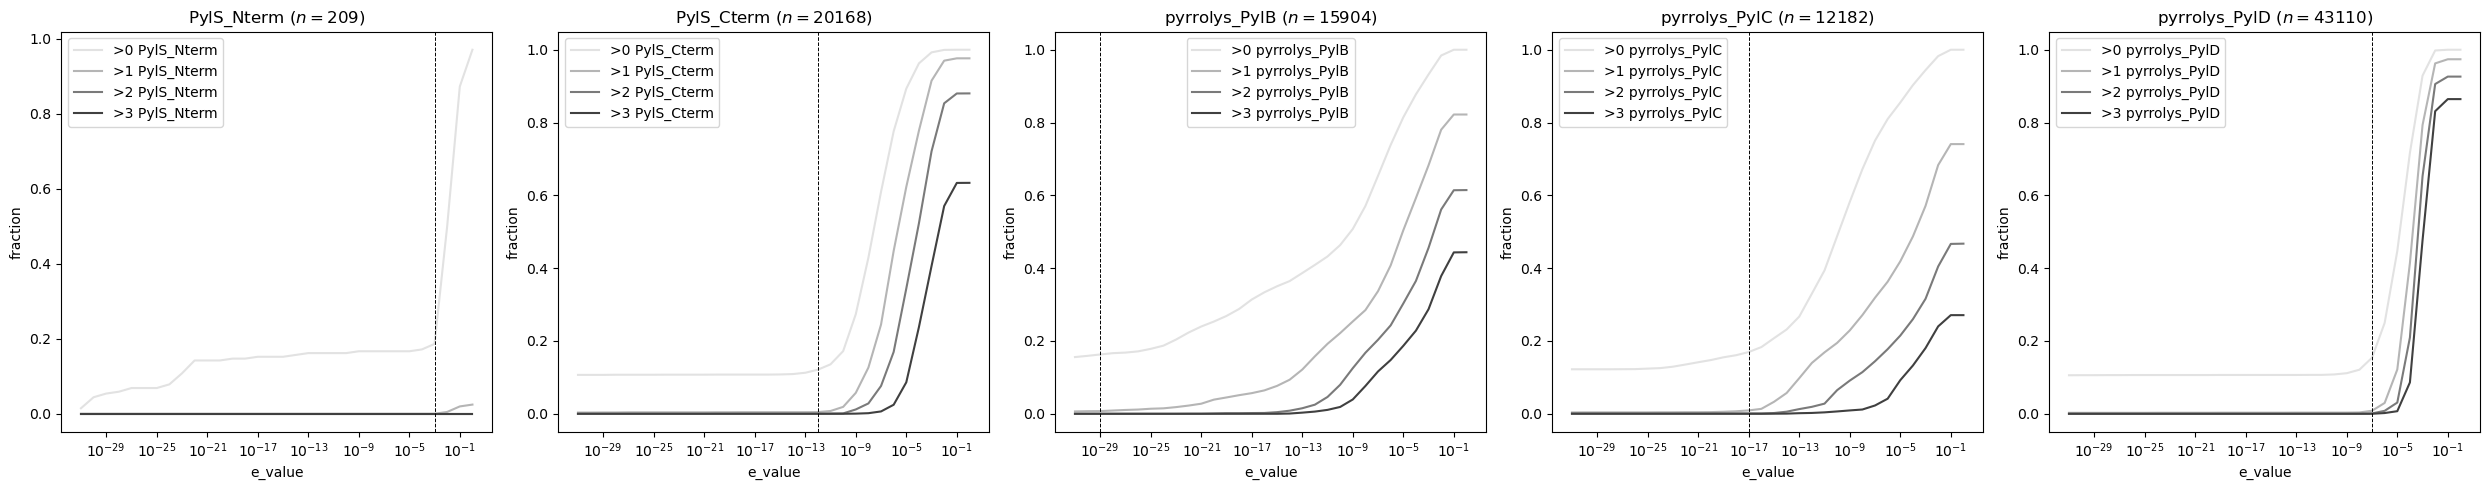

In [9]:
def figure(hmmer_df:pd.DataFrame, pyl_gene:str='pyrrolys_PylD', max_e_value:float=1e-8, ax:plt.Axes=None):
    # fig, ax = plt.subplots()

    # pyl_genes = ['pyrrolys_PylC', 'pyrrolys_PylD', 'pyrrolys_PylB']
    hmmer_df = hmmer_df[hmmer_df.query_name == pyl_gene].copy()

    e_values = [1 / (10**n) for n in range(32)] + [max_e_value]
    n_genomes = hmmer_df.genome_id.nunique() # How many genome IDs have any aRF-1 hit?

    figure_df = list()
    for min_pyl_hits in range(4):
        for e_value in e_values:
            pyl_hits_per_genome = hmmer_df[hmmer_df.e_value < e_value].genome_id.value_counts()
            n = (pyl_hits_per_genome > min_pyl_hits).sum() # Get the number of genomes with more than min_arf1_hits aRF-1 hits.
            figure_df.append({'e_value':e_value, 'fraction':n/n_genomes, 'min_pyl_hits':f'>{min_pyl_hits} {pyl_gene}'})
    figure_df = pd.DataFrame(figure_df)

    figure_df = pd.DataFrame(figure_df)
    sns.lineplot(figure_df, x='e_value', y='fraction', hue='min_pyl_hits', palette='Grays', ax=ax, legend=True)
    ax.set_xscale('log')
    ax.get_legend().set_title('')
    ax.set_title(f'{pyl_gene} ($n={len(hmmer_df)}$)')
    ax.axvline(max_e_value, ls='--', color='black', lw=0.7)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
figure(hmmer_df, ax=axes[0], pyl_gene='PylS_Nterm', max_e_value=1e-3)
figure(hmmer_df, ax=axes[1], pyl_gene='PylS_Cterm', max_e_value=1e-12)
figure(hmmer_df, ax=axes[2], pyl_gene='pyrrolys_PylB', max_e_value=1e-29)
figure(hmmer_df, ax=axes[3], pyl_gene='pyrrolys_PylC', max_e_value=1e-17)
figure(hmmer_df, ax=axes[4], pyl_gene='pyrrolys_PylD', max_e_value=1e-7)
fig.tight_layout()
plt.show()

MAX_E_VALUES = {'pyrrolys_PylB':1e-29, 'pyrrolys_PylC':1e-17, 'pyrrolys_PylD':1e-8}
MAX_E_VALUES.update({'PylS_Nterm':1e-3, 'PylS_Cterm':1e-12})

# Based on examination of plots, it seems as though about 20 percent of genomes should have the entire operon. 
# Want to select thresholds where no (or very few) genomes have multiple copies. 


In [10]:
def get_pyl_genome_ids(hmmer_df, max_e_values:float=MAX_E_VALUES, min_pyl_genes:list=['pyrrolys_PylC', 'pyrrolys_PylD', 'pyrrolys_PylB']):
    '''Return genome IDs which likely have Pyl machinery. This approach is similar to that in the Kivenson 2023 paper to identify
    genomes for organisms which could incorporate pyrrolysine. Default min_pyl_genes are all in the same operon, so should all be present
    if one is present.'''
    hmmer_df = hmmer_df[hmmer_df.query_name.str.contains('Pyl')].copy()
    hmmer_df['max_e_value'] = hmmer_df.query_name.map(max_e_values)
    hmmer_df = hmmer_df[hmmer_df.e_value < hmmer_df.max_e_value].copy() # Strong hits only. 

    # pyl_counts = hmmer_df.groupby('genome_id').apply(lambda df : df.query_name.nunique(), include_groups=False)
    # pyl_genome_ids = pyl_counts[pyl_counts > min_n_pyl_genes].index.values
    pyl_genome_ids = list()
    for genome_id, df in hmmer_df.groupby('genome_id'):
        if np.all(np.isin(min_pyl_genes, df.query_name.unique())):
            pyl_genome_ids.append(genome_id)
        
    return pyl_genome_ids

def get_no_pyl_genome_ids(hmmer_df, max_e_values:dict=MAX_E_VALUES, genome_ids:list=hmmer_df.genome_id.unique(), max_n_pyl_genes:int=0):
    '''Return genome IDs which have no evidence of Pyl machinery'''
    hmmer_df = hmmer_df[hmmer_df.query_name.str.contains('Pyl')].copy()
    hmmer_df['max_e_value'] = hmmer_df.query_name.map(max_e_values)
    hmmer_df['max_e_value'] = hmmer_df.max_e_value * 100 # Make the cutoffs slightly more lenient. 
    # hmmer_df['max_e_value'] = max_e_value 
    hmmer_df = hmmer_df[hmmer_df.e_value < hmmer_df.max_e_value].copy() # Strong hits only. 

    pyl_counts = hmmer_df.groupby('genome_id').apply(lambda df : df.query_name.nunique(), include_groups=False)
    pyl_genome_ids = pyl_counts[pyl_counts > max_n_pyl_genes].index.values # Look for organisms with max_n_pyl_genes or more Pyl genes.
    no_pyl_genome_ids = genome_ids[~np.isin(genome_ids, pyl_genome_ids)]
    return no_pyl_genome_ids.tolist()

pyl_genome_ids = get_pyl_genome_ids(hmmer_df)
no_pyl_genome_ids = get_no_pyl_genome_ids(hmmer_df)

with open('../data/pyl_genome_ids.txt', 'w') as f:
    np.savetxt(f, pyl_genome_ids, fmt='%s')

print('Num. genomes expressing Pyl machinery:', len(pyl_genome_ids))
print('Num. genomes with no evidence of Pyl machinery:', len(no_pyl_genome_ids))
print('Num. ambiguous genomes:', hmmer_df.genome_id.nunique() - (len(pyl_genome_ids) + len(no_pyl_genome_ids)))

Num. genomes expressing Pyl machinery: 511
Num. genomes with no evidence of Pyl machinery: 3125
Num. ambiguous genomes: 1342


In [11]:
if not os.path.exists('../data/arf1.csv'):
    arf1_df = get_arf1_data(hmmer_df, genome_ids=pyl_genome_ids + no_pyl_genome_ids)
    arf1_df.to_csv('../data/arf1.csv')
else:
    arf1_df = pd.read_csv('../data/arf1.csv', index_col=0)

def parse_coords(coords:str):
    '''Parse a string containing the coordinates of each HMM hit, e.g. start..stop,start..stop.'''
    parsed_coords = list()
    for match_ in re.finditer(r'(\d+)\.\.(\d+)', coords):
        coord = (int(match_.group(1)), int(match_.group(2)))
        parsed_coords.append(coord)
    # print(parsed_coords)
    return parsed_coords

def get_min_coord(coords:str):
    return min([coord[0] for coord in parse_coords(coords)])

def get_max_coord(coords:str):
    return max([coord[1] for coord in parse_coords(coords)])

def get_alignment_length(coords:str):
    '''Get the length of the alignment, including gaps.'''
    return get_max_coord(coords) - get_min_coord(coords)

def get_biggest_gap(coords:str):
    '''Get the largest gap between regions of the target sequence which align to the HMM.'''
    coords = parse_coords(coords)   
    gap_sizes = [coords[i + 1][0] - coords[i][1] for i in range(len(coords) - 1)]
    return max(gap_sizes + [0]) # Accounts for there only being one hit. 

arf1_df['has_pyl'] = arf1_df.genome_id.isin(pyl_genome_ids)
arf1_df['query_alignment_start'] = arf1_df.query_coords.apply(get_min_coord)
arf1_df['biggest_query_gap'] = arf1_df.query_coords.apply(get_biggest_gap)
arf1_df['biggest_target_gap'] = arf1_df.envelope_coords.apply(get_biggest_gap)
arf1_df['alignment_length'] = arf1_df.envelope_coords.apply(get_alignment_length)
arf1_df['genus'] = arf1_df.genome_id.map(genome_metadata_df.genus)
arf1_df['order'] = arf1_df.genome_id.map(genome_metadata_df['order'])


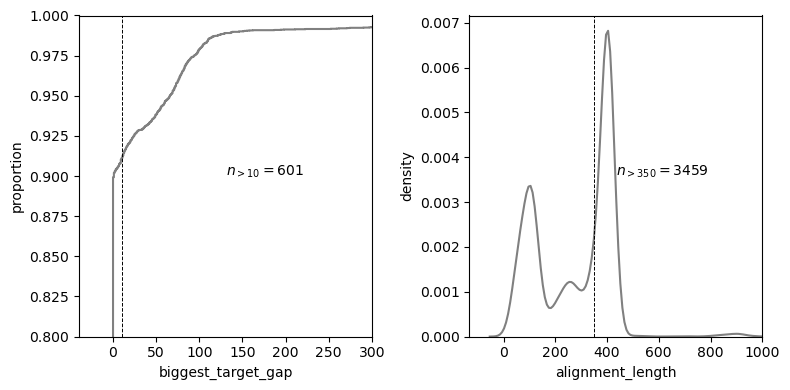

In [12]:
def figure(arf1_df:pd.DataFrame, max_gap:int=100, min_alignment_length:int=350):
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(8, 4))

    sns.ecdfplot(arf1_df, x='biggest_target_gap', ax=ax_a, color='gray')
    ax_a.axvline(max_gap, ls='--', color='black', lw=0.7)
    n = (arf1_df.biggest_target_gap > max_gap).sum()
    text = '$n_{>' + str(max_gap) + '}=$' + str(n)
    ax_a.text(0.5, 0.5, text, transform=ax_a.transAxes)
    ax_a.set_xlim(xmax=300)
    ax_a.set_ylim(ymin=0.8)
    ax_a.set_ylabel('proportion')

    sns.kdeplot(arf1_df, x='alignment_length', color='gray', ax=ax_b)
    ax_b.set_ylabel('density')
    ax_b.set_xlim(xmax=1000)
    ax_b.axvline(min_alignment_length, ls='--', color='black', lw=0.7)
    n = (arf1_df.alignment_length > min_alignment_length).sum()
    text = '$n_{>' + str(min_alignment_length) + '}=$' + str(n)
    ax_b.text(0.5, 0.5, text, transform=ax_b.transAxes)

    plt.tight_layout()
    plt.show()

figure(arf1_df, max_gap=10)


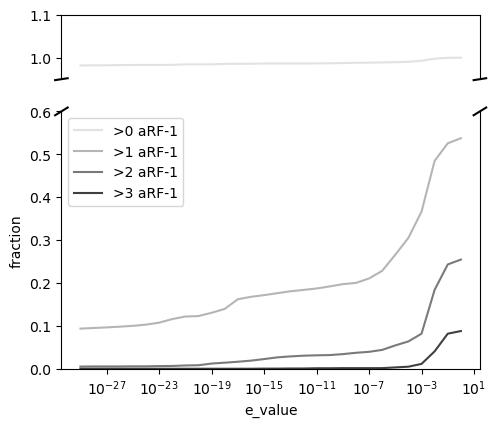

In [13]:
# We know that all organisms should have at least one type I release factor, so should select an E-value accordingly. 
# Plot the fraction of genomes with at least one annotated aRF-1 by selected threshold. 
def figure(arf1_df:pd.DataFrame):
    fig, (ax_top, ax_bottom) = get_split_figure((0, 0.6), (0.95, 1.1))

    e_values = [1 / (10**n) for n in range(30)]
    n_genomes = arf1_df.genome_id.nunique() # How many genome IDs have any aRF-1 hit?

    figure_df = list()
    for min_arf1_hits in range(4):
        for e_value in e_values:
            arf1_hits_per_genome = arf1_df[arf1_df.e_value < e_value].genome_id.value_counts()
            n = (arf1_hits_per_genome > min_arf1_hits).sum() # Get the number of genomes with more than min_arf1_hits aRF-1 hits.
            figure_df.append({'e_value':e_value, 'fraction':n/n_genomes, 'min_arf1_hits':f'>{min_arf1_hits} aRF-1'})
    figure_df = pd.DataFrame(figure_df)

    sns.lineplot(figure_df, x='e_value', y='fraction', hue='min_arf1_hits', palette='Grays', ax=ax_top, legend=False)
    sns.lineplot(figure_df, x='e_value', y='fraction', hue='min_arf1_hits', palette='Grays', ax=ax_bottom, legend=True)
    ax_bottom.get_legend().set_title('')
    ax_top.set_xscale('log')
    ax_top.set_ylabel('')
    ax_bottom.set_xscale('log')
    plt.show()

figure(arf1_df)
# We know that almost nothing should have more than 2 aRF-1s.

ARF1_MAX_E_VALUE = 1e-17


In [14]:
# Steps to filter out any potential false positives. 
filters = dict()
filters['e_value'] = arf1_df.e_value < ARF1_MAX_E_VALUE
filters['partial'] = ~arf1_df.partial
filters['max_target_gap'] = arf1_df.biggest_target_gap < 20 
filters['max_query_gap'] = arf1_df.biggest_query_gap < 5 
filters['min_alignment_length'] = arf1_df.alignment_length > 350
filters['has_ggq_domain'] = arf1_df.seq.str.contains('GGQ')

n = len(arf1_df)

for filter_name, mask in filters.items():
    print(f'Num. sequences removed by filter {filter_name}:', (~mask).sum(), f'({100 * (~mask).sum() / n:.2f}%)')

masks = list(filters.values())
mask = masks[0]
for mask_ in masks:
    mask = np.logical_and(mask, mask_)

arf1_df = arf1_df[mask].copy()

arf1_df['has_pyl'] = arf1_df.genome_id.isin(pyl_genome_ids)
arf1_df['has_niks_domain'] = arf1_df.seq.str.contains(niks_domain, regex=True)
arf1_df['has_ycf_domain'] = arf1_df.seq.str.contains(ycf_domain)

Num. sequences removed by filter e_value: 2637 (38.90%)
Num. sequences removed by filter partial: 405 (5.97%)
Num. sequences removed by filter max_target_gap: 536 (7.91%)
Num. sequences removed by filter max_query_gap: 856 (12.63%)
Num. sequences removed by filter min_alignment_length: 3320 (48.97%)
Num. sequences removed by filter has_ggq_domain: 3086 (45.52%)


In [15]:
# Some fraction of the genomes still have multiple aRF1s. 
genome_ids_multiple_arf1s = arf1_df.genome_id.value_counts()[arf1_df.genome_id.value_counts() > 1].index

orders_multiple_arfs = arf1_df[arf1_df.genome_id.isin(genome_ids_multiple_arf1s)].drop_duplicates('genome_id').order
genuses_multiple_arfs = arf1_df[arf1_df.genome_id.isin(genome_ids_multiple_arf1s)].drop_duplicates('genome_id').genus

order_counts = arf1_df.drop_duplicates('genome_id').order.value_counts()
genus_counts = arf1_df.drop_duplicates('genome_id').genus.value_counts()

arf1_df = arf1_df.sort_values('e_value')
arf1_1_df = arf1_df[arf1_df.genome_id.isin(genome_ids_multiple_arf1s)].drop_duplicates('genome_id', keep='first').copy()
arf1_2_df = arf1_df[arf1_df.genome_id.isin(genome_ids_multiple_arf1s)].drop_duplicates('genome_id', keep='last').copy()

genome_id_to_species_map = table_2_metadata_df.organism_name.to_dict()
genome_id_to_species_map.update(gtdb_metadata_df.gtdb_taxonomy.apply(get_species).to_dict())
genome_id_to_species_map['GCA_033485125.1'] = 'Methanosarcina sp. A'
genome_id_to_species_map['GCA_033485095.1'] = 'Methanosarcina sp. B'
genome_id_to_species_map['GCA_033485115.1'] = 'Methanosarcina sp. C'
genome_id_to_species_map['GCA_028693135.1'] = 'Methanosarcina sp. D'

arf1_1_df['arf1_type'] = 'aRF1-1'
arf1_2_df['arf1_type'] = 'aRF1-2'
arf1_duplicates_df = pd.concat([arf1_1_df, arf1_2_df])
arf1_duplicates_df['species'] = arf1_duplicates_df.genome_id.map(genome_id_to_species_map)

# arf1_duplicates_df['id'] = [f'{row.species} {row.arf1_type}' for row in arf1_duplicates_df.itertuples()]
arf1_duplicates_df['name'] = [f'{row.genome_id}_{row.arf1_type}' for row in arf1_duplicates_df.itertuples()]

FASTAFile().from_df(arf1_duplicates_df.set_index('name').drop(columns=['description'])).write('../data/arf1_duplicates.fa')
arf1_duplicates_df.to_csv('../data/arf1_duplicates.csv')

palette = {'aRF1-1':red, 'aRF1-2':blue}
widths = {'aRF1-1':4, 'aRF1-2':4}
make_itol_annotation_file(arf1_duplicates_df, path='../data/arf1_duplicates_tree_annotation.txt', field='arf1_type', widths=widths, palette=palette)

arf1_df = arf1_df.drop_duplicates('genome_id').copy() # Keep the aRF1 with the best E-value. 
print('Num. aRF-1 sequences in final dataset:', len(arf1_df))

Num. aRF-1 sequences in final dataset: 2803


In [16]:
# To make sure I grab the entire relevant region, perhaps take the stop coordinate of the first set of envelope coordinates, 
# and then check post-hoc to see how long the aligned region is.  

# arf1_df.drop(columns=['genome_id_x']).rename(columns={'genome_id_y':'genome_id'}).to_csv('../data/arf1.csv')
print('Num. genomes:', len(pyl_genome_ids) + len(no_pyl_genome_ids))
print('Num. genomes with an annotated aRF-1:', arf1_df.genome_id.nunique())
print('Num. Pyl genomes with an annotated aRF-1:', arf1_df[arf1_df.has_pyl].genome_id.nunique())
print('Num. non-Pyl genomes with an annotated aRF-1:', arf1_df[~arf1_df.has_pyl].genome_id.nunique())

FASTAFile().from_df(arf1_df).write('../data/arf1_cleaned.fa')
arf1_df.to_csv('../data/arf1_cleaned.csv')

Num. genomes: 3636
Num. genomes with an annotated aRF-1: 2803
Num. Pyl genomes with an annotated aRF-1: 473
Num. non-Pyl genomes with an annotated aRF-1: 2330


figure: Num. represented order: 10


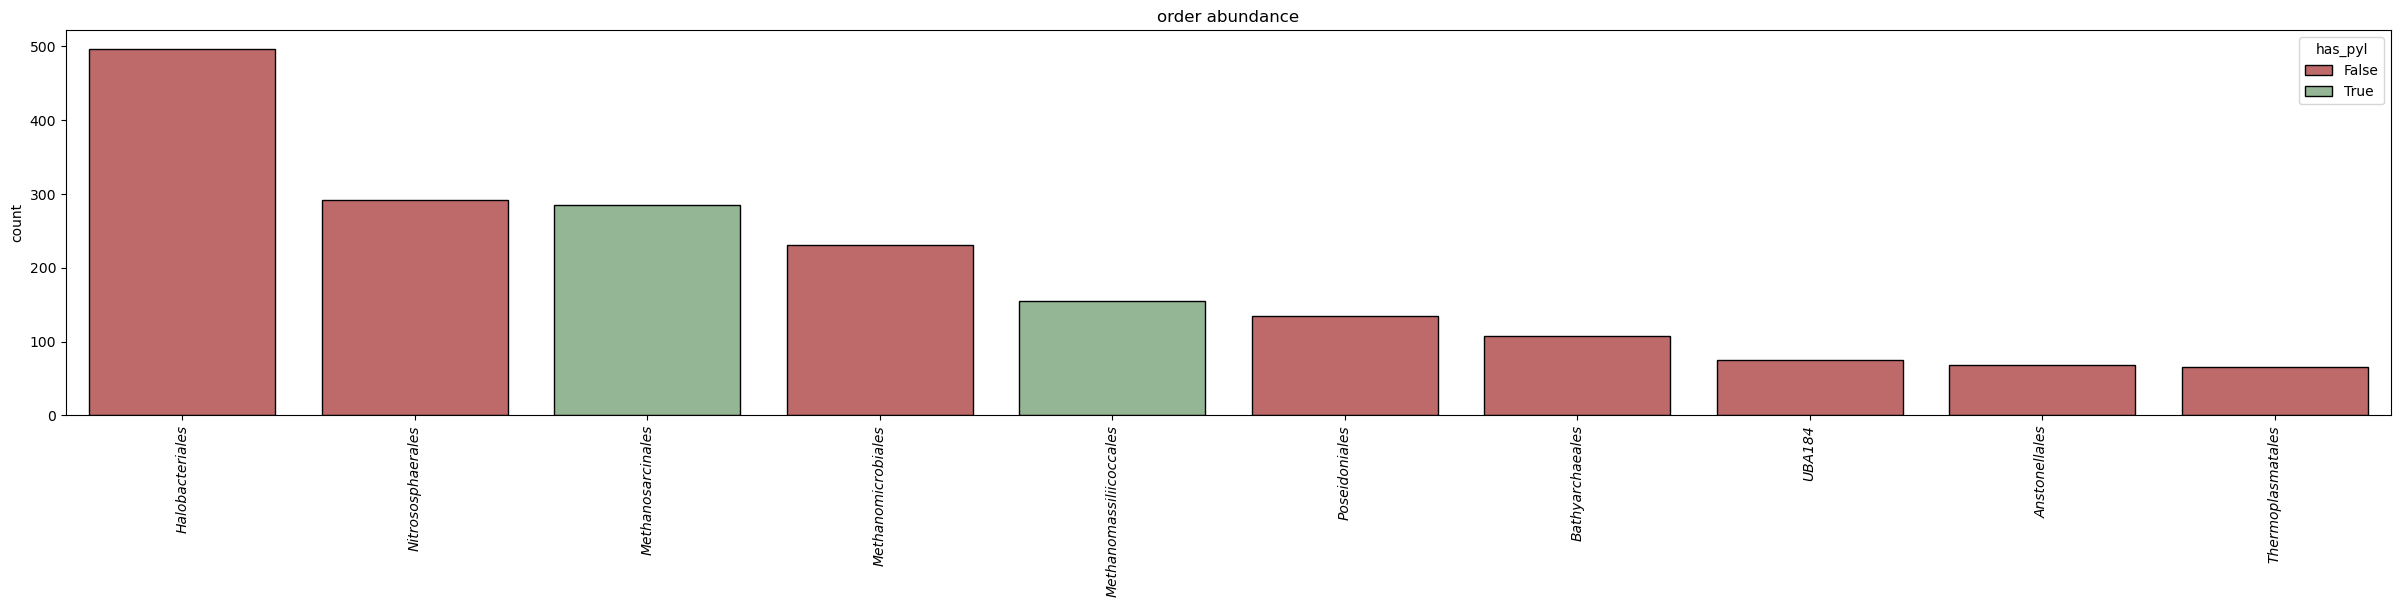

In [58]:
fig, ax = plt.subplots(figsize=(30, 5))
level = 'order'
n = 10

figure_df = arf1_df.copy()

taxa_counts = arf1_df.value_counts([level, 'has_pyl'], sort=True)
taxa_counts = taxa_counts.iloc[:n]
figure_df = pd.DataFrame(taxa_counts)
figure_df[level] = taxa_counts.index.get_level_values(level)
figure_df['has_pyl'] = taxa_counts.index.get_level_values('has_pyl')

print(f'figure: Num. represented {level}: {len(taxa_counts)}')

sns.barplot(figure_df, x=level, y='count', hue='has_pyl', palette={True:'darkseagreen', False:'indianred'}, edgecolor='black')
ax.set_ylabel('count')
ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90, style='italic')
ax.set_title(f'{level} abundance')
ax.set_xlabel('')

plt.show()

In [18]:
# # query,target,evalue,pident,bits,qseq,tseq,alnlen,qstart,qend,tstart,tend,mismatch,gapopen

# if not os.path.exists('../data/arf1_cleaned_align.csv'):
#     cols = ['query_id', 'target_id', 'e_value', 'percent_identity', 'bit_score', 'query_seq', 'target_seq', 'alignment_length']
#     cols += ['query_start', 'query_stop', 'target_start', 'target_stop', 'mismatch', 'gap_open']
#     align_df = pd.read_csv('../data/arf1_cleaned_align.tsv', sep='\t', header=None, names=cols)
#     align_df = align_df[align_df.e_value < 1e-5].copy()
#     align_df = align_df[align_df.target_id != align_df.query_id].copy() # Remove self-alignments.get_pair_id = lambda row : '-'.join(sorted([row.query_id, row.target_id]))

#     get_pair_id = lambda row : '-'.join(sorted([row.query_id, row.target_id]))

#     align_df['target_genome_id'] = align_df.target_id.map(arf1_df.genome_id)
#     align_df['query_genome_id'] = align_df.query_id.map(arf1_df.genome_id)
#     align_df['pair_id'] = align_df.apply(get_pair_id, axis=1)
#     align_df = align_df.drop_duplicates('pair_id')
#     align_df.to_csv('../data/arf1_cleaned_align.csv')
# else:
#     align_df = pd.read_csv('../data/arf1_cleaned_align.csv', index_col=0)

In [55]:
widths = {True:5, False:1}
make_itol_annotation_file(arf1_df, path='../data/arf1_cleaned_tree_annotation_1.txt', field='has_pyl', widths=widths, palette={True:green, False:red})